# Lendingclub 데이터로 부도 예측하기(LPM/Logistic, 결정트리, 랜덤포레스트)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Data load

In [ ]:
#필요한 모듈 불러오기
from pandas import DataFrame, Series
import numpy as np
import pandas as pd
import os
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sb
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 한글 출력 시 (Colab 용)
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf
plt.rc('font', family='NanumBarunGothic')

# 마이너스 기호 깨짐 현상 해결
#mpl.rcParams['axes.unicode_minus'] = False 

In [ ]:
#파일 불러오기/content/lendingclub.dta
#df = pd.io.stata.read_stata('/content/drive/MyDrive/lendingclub.dta')
df = pd.io.stata.read_stata('/content/drive/MyDrive/빅데이터와 핀테크/FinTech 4기/조별 성취도 평가 안내/lendingclub.dta')
#data.to_csv('lendingclub.csv')

In [ ]:
#df = pd.read_stata('./lendingclub.dta')

In [ ]:
df.shape

(1092919, 333)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1092919 entries, 0 to 1092918
Columns: 333 entries, loan_amnt to mths_since_recent_revol_delinq11
dtypes: float32(2), float64(16), int16(6), int32(6), int8(303)
memory usage: 503.4 MB


In [ ]:
df.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,...,mths_since_recent_bc4,mths_since_recent_bc5,mths_since_recent_bc6,mths_since_recent_bc7,mths_since_recent_bc8,mths_since_recent_bc9,mths_since_recent_bc10,mths_since_recent_bc11,mths_since_recent_bc_dlq1,mths_since_recent_bc_dlq2,mths_since_recent_bc_dlq3,mths_since_recent_bc_dlq4,mths_since_recent_bc_dlq5,mths_since_recent_bc_dlq6,mths_since_recent_bc_dlq7,mths_since_recent_bc_dlq8,mths_since_recent_bc_dlq9,mths_since_recent_bc_dlq10,mths_since_recent_bc_dlq11,mths_since_recent_inq1,mths_since_recent_inq2,mths_since_recent_inq3,mths_since_recent_inq4,mths_since_recent_inq5,mths_since_recent_inq6,mths_since_recent_inq7,mths_since_recent_inq8,mths_since_recent_inq9,mths_since_recent_inq10,mths_since_recent_revol_delinq1,mths_since_recent_revol_delinq2,mths_since_recent_revol_delinq3,mths_since_recent_revol_delinq4,mths_since_recent_revol_delinq5,mths_since_recent_revol_delinq6,mths_since_recent_revol_delinq7,mths_since_recent_revol_delinq8,mths_since_recent_revol_delinq9,mths_since_recent_revol_delinq10,mths_since_recent_revol_delinq11
count,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,...,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06,1.092919e+06
mean,1.364630e+04,1.364628e+04,1.364033e+04,1.263927e-01,4.312534e+02,7.562999e+04,1.818105e+01,3.394543e-01,6.942867e+02,6.982868e+02,6.401874e-01,1.157962e+01,2.278147e-01,1.633953e+04,5.311223e-01,2.472208e+01,1.688434e-01,1.688348e-01,1.488750e+04,1.488104e+04,1.221735e+04,2.466102e+03,1.806582e+00,2.022404e+02,3.361854e+01,3.916907e+03,6.790201e+02,6.632270e+02,1.791258e-02,5.880582e-03,2.452099e+02,1.349993e+05,9.476457e-03,1.640168e+01,1.329669e-01,6.108504e-02,6.535251e-02,3.302212e-01,9.019790e-02,7.987692e-02,...,7.996475e-02,1.008492e-01,1.119479e-01,8.370154e-02,1.024037e-01,9.419088e-02,9.277906e-02,9.844279e-02,7.448054e-01,2.708526e-02,2.611904e-02,2.605866e-02,2.619133e-02,2.569358e-02,2.544104e-02,2.352141e-02,2.559476e-02,2.482801e-02,2.466148e-02,1.063400e-01,1.790526e-01,1.525328e-01,6.588777e-02,5.867498e-02,1.023278e-01,8.212777e-02,9.045776e-02,8.048812e-02,8.211039e-02,6.449353e-01,3.838070e-02,3.805314e-02,3.610332e-02,3.453504e-02,3.227595e-02,3.575745e-02,3.779146e-02,3.360908e-02,3.576935e-02,3.278926e-02
std,8.441163e+03,8.441145e+03,8.438033e+03,4.361999e-02,2.652486e+02,8.994245e+04,8.321510e+00,9.065449e-01,3.061425e+01,3.061490e+01,9.343720e-01,5.429423e+00,6.400227e-01,2.264732e+04,2.389062e-01,1.186147e+01,1.768506e+01,1.768472e+01,1.028781e+04,1.028402e+04,8.515152e+03,2.673396e+03

## 2. Data Preprocessing

### 2.1 결측치 처리

Text(0, 0.5, 'Feature count')

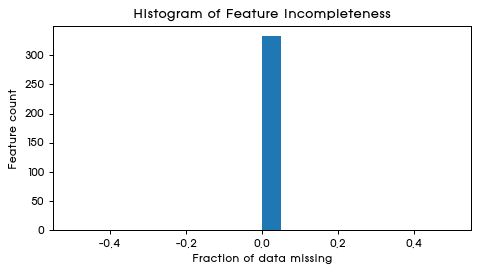

In [ ]:
#결측치 비율 확인
missing_fractions = df.isnull().mean().sort_values(ascending=False)

plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

### 2.2. 후행 변수 제거

In [ ]:
#후행 변수 제거
columns = ['out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv',
           'total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries',
           'collection_recovery_fee','last_pymnt_amnt','last_fico_range_high',
           'last_fico_range_low','elapsed_t','debt_settlement_flag1','term1']
           
df2 = df.drop(columns,axis=1)

In [ ]:
#후행 변수의 영향 확인
result = []
#thres = ???

for i in range(len(df['recoveries'])):
  if df['recoveries'][i]!=0:
    result.append(1)
  else :
    result.append(0)

mat = confusion_matrix(df['depvar'],result)
mat

array([[916095,      0],
       [ 37777, 139047]])

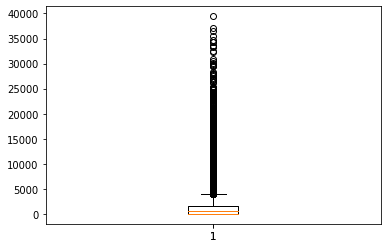

In [ ]:
x1 = df['recoveries'][df['depvar']==0]
x2 = df['recoveries'][df['depvar']==1]
plt.boxplot(x1)
plt.boxplot(x2)
plt.show()

In [ ]:
#시간(t)을 나타내는 변수(=issue_d) 제거
issues = df2.iloc[:,111:230].columns
df3 = df2.drop(issues,axis=1)

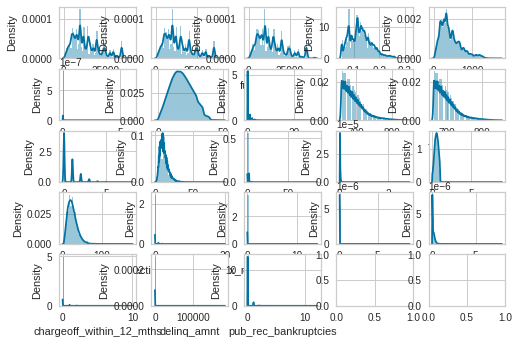

In [ ]:
#연속형 변수의 분포 파악
df_quan = df3.iloc[:,:23]
cols = df_quan.columns

m = [0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4]
n = [0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4]

f,axes = plt.subplots(5,5)
for col,m,n in zip(cols,m,n):
  sb.distplot(df_quan[col],ax=axes[m,n])

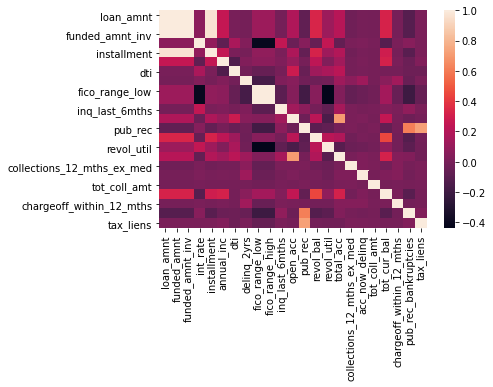

In [ ]:
#연속형 변수 상관계수 확인
df_quan = df3.iloc[:,:23]
sb.heatmap(df_quan.corr(), annot=False, fmt='.2f')

### 2.3 상관관계 - 분산팽창지수 확인 (VIF)

In [ ]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
features="loan_amnt+funded_amnt+funded_amnt_inv+int_rate+installment+annual_inc+dti+fico_range_low+fico_range_high+open_acc+pub_rec+revol_util+total_acc+tot_cur_bal+pub_rec_bankruptcies"

In [ ]:
y, X = dmatrices("depvar ~" + features, data=df3, return_type = "dataframe")

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

result = sm.OLS(y,X).fit()

In [ ]:
print(result.summary())
#다중회귀분석이기 때문에 R-squared값 대신 Adj. R-squared값을 보자. Adj. R-squared값이 0.225로 나와있는 것을 볼 수 있다. 이는 회귀모형의 설명력이 22.5%라는 뜻
#F값이 12.02, 유의확률(Pr>F)은 0.000

                            OLS Regression Results                            
Dep. Variable:                 depvar   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     4440.
Date:                Sat, 30 Jan 2021   Prob (F-statistic):               0.00
Time:                        04:24:04   Log-Likelihood:            -4.2667e+05
No. Observations:             1092919   AIC:                         8.534e+05
Df Residuals:                 1092903   BIC:                         8.536e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0880 

In [ ]:
# VIF 체크
y, X = dmatrices("depvar ~" + features, data=df3, return_type = "dataframe")
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [ ]:
vif.round(1)

,VIF Factor,features
0,122679.0,Intercept
1,454932.7,loan_amnt
2,535539.5,funded_amnt
3,79539.4,funded_amnt_inv
4,1.3,int_rate
5,17.6,installment
6,1.2,annual_inc
7,1.2,dti
8,7189588.5,fico_range_low
9,7189533.0,fico_range_high


In [ ]:
#중복되는 열 처리 -> 근거 : vif 확인
df4 = df3.drop(['loan_amnt','funded_amnt','installment','fico_range_high','open_acc','revol_util','pub_rec_bankruptcies'],axis=1)

In [ ]:
#features="funded_amnt+int_rate+annual_inc+dti"

In [ ]:
# VIF 체크
#y, X = dmatrices("depvar ~" + features, data=df, return_type = "dataframe")
#vif = pd.DataFrame()
#vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#vif["features"] = X.columns

In [ ]:
#vif.round(1)

,VIF Factor,features
0,15.6,Intercept
1,1.0,funded_amnt
2,1.0,int_rate
3,1.0,annual_inc
4,1.0,dti


In [ ]:
list(df4.columns)

['funded_amnt_inv',
 'int_rate',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'inq_last_6mths',
 'pub_rec',
 'revol_bal',
 'total_acc',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'tax_liens',
 'emp_length1',
 'emp_length2',
 'emp_length3',
 'emp_length4',
 'emp_length5',
 'emp_length6',
 'emp_length7',
 'emp_length8',
 'emp_length9',
 'emp_length10',
 'emp_length11',
 'emp_length12',
 'home_ownership1',
 'home_ownership2',
 'home_ownership3',
 'home_ownership4',
 'home_ownership5',
 'home_ownership6',
 'verification_status1',
 'verification_status2',
 'verification_status3',
 'purpose1',
 'purpose2',
 'purpose3',
 'purpose4',
 'purpose5',
 'purpose6',
 'purpose7',
 'purpose8',
 'purpose9',
 'purpose10',
 'purpose11',
 'purpose12',
 'purpose13',
 'purpose14',
 'addr_state1',
 'addr_state2',
 'addr_state3',
 'addr_state4',
 'addr_state5',
 'addr_state6',
 'addr_state7',
 'addr_state8',
 'a

In [ ]:
df4.shape

(1092919, 192)

### 2.4 Down Sampling

In [ ]:
#전체 data 중 부도가 난 사람들의 비율(16%)
before_a=len(df[df['depvar']==1])
before_b=len(df[df['depvar']==0])

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

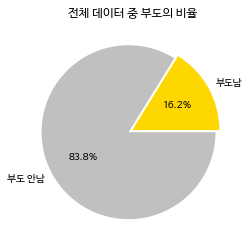

In [ ]:
plt.title("전체 데이터 중 부도의 비율")
plt.pie([before_a,before_b],labels=['부도남','부도 안남'],autopct='%.1f%%',explode=[0,0.05],colors=['gold','silver'])
plt

In [ ]:
#down샘플링
df_0 = df4.loc[df4['depvar']==0]
df_1 = df4.loc[df4['depvar']==1]

n_df_0 = len(df_0)
n_df_1 = len(df_1)

df_0_down = df_0.sample(n = n_df_1, replace = False)

df = pd.concat([df_0_down,df_1],ignore_index=True)

len(df['depvar'][df['depvar']==0])/len(df['depvar'])

0.5

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

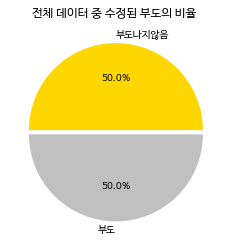

In [ ]:
plt.title("전체 데이터 중 수정된 부도의 비율 ")
plt.pie([len(df['depvar'][df['depvar']==0]),len(df['depvar'][df['depvar']==1])],labels=['부도나지않음','부도'],autopct='%.1f%%',explode=[0,0.05],colors=['gold','silver'])
plt

### 2.5 스케일링

#### 2.5.1 데이터 분리

In [ ]:
df4['int_rate'].describe()

count    1.092919e+06
mean     1.263927e-01
std      4.361999e-02
min      5.320000e-02
25%      9.170000e-02
50%      1.229000e-01
75%      1.531000e-01
max      3.099000e-01
Name: int_rate, dtype: float64

In [ ]:
X = df.drop('depvar', axis=1)
y = df['depvar']

In [ ]:
# data를 training set과 test set으로 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=43)

#### 2.5.2 RobustScaler 

In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
robustScaler = RobustScaler()
robustScaler.fit(X_train)
X_train = robustScaler.transform(X_train)
X_test = robustScaler.transform(X_test)

## 3. 모델 생성(지도학습)

### 3.1 선형 회귀(LinearRegression)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
linearReg = LinearRegression().fit(X_train,y_train)

In [ ]:
print("Linear_reg 훈련 세트 정확도 : {:.3f}".format(linearReg.score(X_train,y_train)))
print("Linear_reg 테스트 세트 정확도 : {:.3f}".format(linearReg.score(X_test,y_test)))

Linear_reg 훈련 세트 정확도 : 0.716
Linear_reg 테스트 세트 정확도 : 0.716


In [ ]:
y_predict1 = linearReg.predict(X_test) 

In [ ]:
thres = 0.26
y_pred = []

for i in y_predict1:
  if i>thres :
    y_pred.append(1)
  else :
    y_pred.append(0)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc
from sklearn.metrics import confusion_matrix

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.5524954050615015
[[ 4779 30673]
 [  979 34299]]


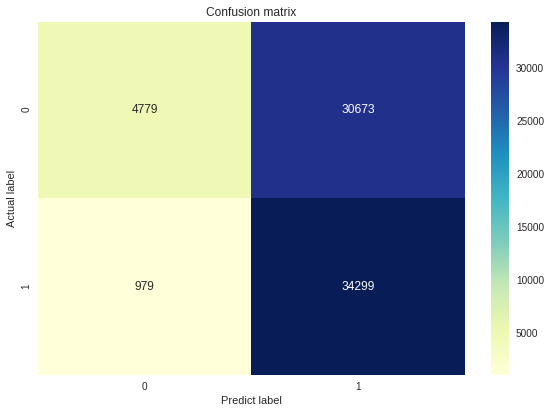

In [ ]:
lpm_con = confusion_matrix(y_test, y_pred)

sb.heatmap(pd.DataFrame(lpm_con), annot=True, cmap='YlGnBu', fmt='g')
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predict label")
plt.show()

### 3.2 결정 트리(DecisionTree)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
tree = DecisionTreeClassifier(random_state=0).fit(X_train,y_train)

In [ ]:
print("Tree 훈련 세트 정확도 : {:.3f}".format(tree.score(X_train,y_train)))
print("Tree 테스트 세트 정확도 : {:.3f}".format(tree.score(X_test,y_test)))

Tree 훈련 세트 정확도 : 1.000
Tree 테스트 세트 정확도 : 0.555


In [ ]:
y_pred_tree = tree.predict(X_test) 

In [ ]:
print(accuracy_score(y_test,y_pred_tree))
confusion_matrix(y_test,y_pred_tree)

0.5552382298883076


array([[19749, 15703],
       [15755, 19523]])

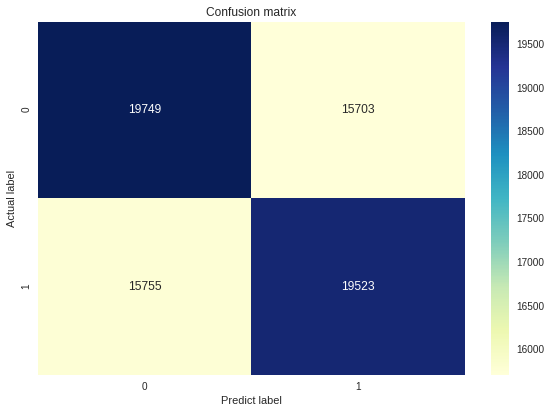

In [ ]:
a = confusion_matrix(y_test, y_pred_tree)

sb.heatmap(a, annot=True, cmap='YlGnBu', fmt='g')
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predict label")
plt.show()

AUC : 0.555233729599355


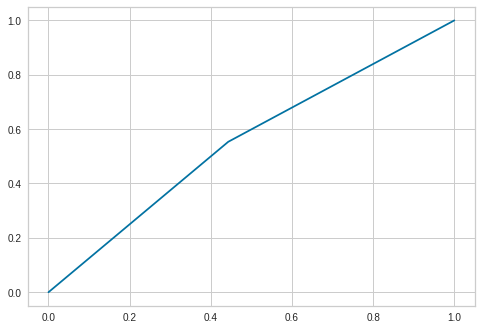

In [ ]:
## tree AUC, ROC Curve
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test,y_pred_tree)

# print ROC curve
plt.plot(fpr_tree,tpr_tree)

# print AUC
auc_tree = np.trapz(tpr_tree,fpr_tree)
print("AUC :",auc_tree)

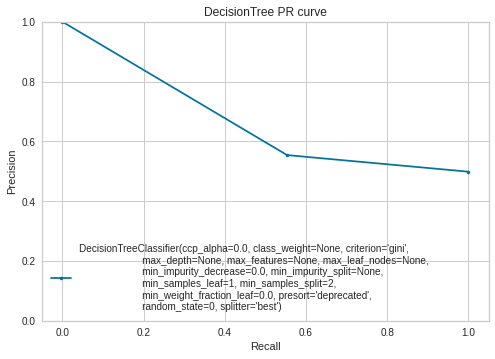

In [ ]:
#pr curve
from sklearn.metrics import precision_recall_curve
def plot_pr_curve(test_y, model_probs ,clf_name):
    precision, recall, _ = precision_recall_curve(test_y, model_probs)
    plt.plot(recall, precision, marker='.', label=clf_name)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    plt.ylim(0,1)

plot_pr_curve(y_test, y_pred_tree,tree)
plt.title("DecisionTree PR curve")
plt.show()

### 3.3 랜덤 포레스트(RandomForest)

In [ ]:
#모듈 임포트
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz

from imblearn.under_sampling import *
from yellowbrick.classifier import ROCAUC

In [ ]:
#pip install imblearn

In [ ]:
#import sys
#!conda install pip     # pip 미설치일 경우
#!{sys.executable} -m pip install yellowbrick

In [ ]:
#하이퍼파라미터 튜닝
#Rule of Thumb에 의해
#max_features : 분류기의 종류를 다양화하기 위해 적절히 적은 수가 필요하다. 데이터 셋의 특성 수에 제곱근을 취한 값과 log2를 취한 값.
#max_depth : 과적합을 피하기 위해 일정 수준의 불순도를 달성하게 해주는 트리 깊이.
#min_impurity_split : Leaf의 Impurity가 너무 작으면 과적합 문제가 있으므로 leaf의 일정 수준 불순도를 지정.
#특정 validation set에 대한 과적합을 막기 위해 cv=3 시행.
#impurity limit에 적은 값을 넣어도 depth가 작으면 최종 leaf의 불순도는 전반적으로 높다. 반대 역시 성립.
#랜덤포레스트의 보팅 방식은 샘플들에 대한 평균이므로 이를 threshold와 비교하기 위해서는 샘플 간 도출된 값이 비교적 균일해야한다. 

params = {'n_estimators' : [10],
           'max_depth' : [4,6,8],
           'min_impurity_split' : [0.1, 0.2, 0.3, 0.4],
           'max_features' : [7, 14]}

rf_clf = RandomForestClassifier(random_state = 13, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv=3, scoring='accuracy', n_jobs=-1)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=13,
                                    

In [ ]:
print(grid_cv.best_params_)
print(grid_cv.best_score_)

{'max_depth': 8, 'max_features': 14, 'min_impurity_split': 0.2, 'n_estimators': 10}
0.6312853901130362


In [ ]:
#모델링
#파라미터 튜닝을 통해 나온 값을 대입하여 트레이닝
forest = RandomForestClassifier(n_estimators=10,max_depth=8,min_impurity_split=0.3,max_features=14,random_state=1217)
trainings = forest.fit(X_train, y_train)


In [ ]:
#test set의 예측부도확률과 정확도,정밀도,매트릭스 도출
y_pred_rf = trainings.predict(X_test)
y_pred_lasso = cut_off(y_pred_rf, 0.26)
print(accuracy_score(y_test, y_pred_rf))
print(precision_score(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))


0.6276544606249116
0.6130753667172484
[[20153 15299]
 [11037 24241]]


(array([  253.,  1712.,  4112.,  7093., 10096., 14053., 17449., 12438.,
         3381.,   143.]),
 array([0.20583121, 0.2581964 , 0.31056158, 0.36292676, 0.41529195,
        0.46765713, 0.52002231, 0.5723875 , 0.62475268, 0.67711786,
        0.72948305]),
 <a list of 10 Patch objects>)

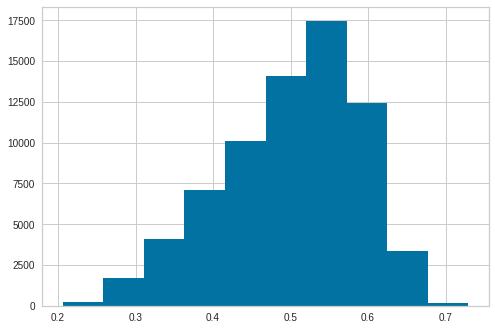

In [ ]:
#예측부도확률은 10개 샘플 트리에서 도출된 값의 평균이다.
pred_prob_list = list(trainings.predict_proba(X_test))
pred_prob = []

for i in range(len(pred_prob_list)):
  prob_ = pred_prob_list[i][1]
  pred_prob.append(prob_)

#predict_prob의 분포 : 가운데에 있는 항목일수록 불순도가 높다. 
plt.hist(pred_prob)

In [ ]:
#threshold를 바꾸었을 때의 정확도,정밀도,매트릭스 도출
y_pred_thres = []
thres = 0.26

for i in pred_prob :
  if i <= thres :
    y_pred_thres.append(0)
  else :
    y_pred_thres.append(1)

print(accuracy_score(y_test, y_pred_thres))
print(precision_score(y_test, y_pred_thres))
print(confusion_matrix(y_test, y_pred_thres))

0.5019652198501343
0.5003690665455371
[[  254 35198]
 [   28 35250]]


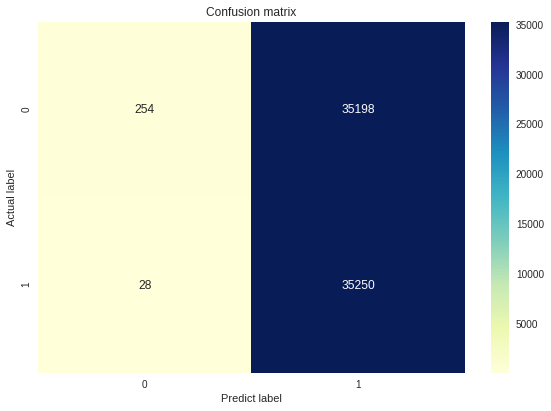

In [ ]:
a = confusion_matrix(y_test, y_pred_thres)

sb.heatmap(a, annot=True, cmap='YlGnBu', fmt='g')
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predict label")
plt.show()

In [ ]:
#각 조건에 맞는 threshold 찾기
acc_score=[]
pre_score=[]
rec_score=[]

for t in np.linspace(0, 1, num=100) :
  y_pred_thres = []
  thres = t

  for i in pred_prob :
    if i <= thres :
      y_pred_thres.append(0)
    else :
      y_pred_thres.append(1)

  acc_score.append(accuracy_score(y_test, y_pred_thres))
  pre_score.append(precision_score(y_test, y_pred_thres))
  #rec_score.append(recall_score(y_test, y_pred_thres))

In [ ]:
best_thres = 0.5*(np.array(pre_score) + np.array(acc_score))
best_thres = list(best_thres)

#print(best_thres.index(max(best_thres)))
print(acc_score.index(max(acc_score)))
#print(pre_score.index(max(pre_score)))
#print(rec_score.index(max(rec_score)))

50


(array([35452.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 35278.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

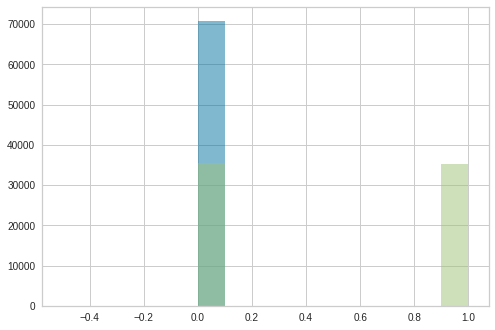

In [ ]:
#좌측 기둥의 상단 : false negative
#우측 기둥의 상단 : true negative
plt.hist(y_pred_thres,alpha=.5)
plt.hist(y_test,alpha=.5)

0.6342509136923066

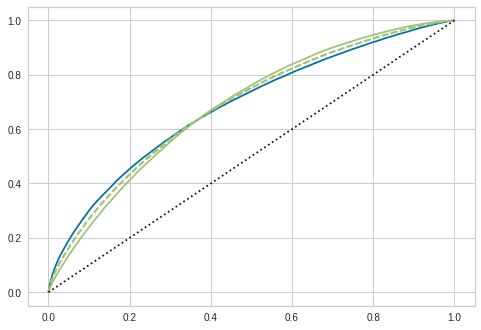

In [ ]:
#roc curve
visualizer = ROCAUC(forest, classes=[0,1])
visualizer.fit(X_train,y_train)
visualizer.score(X_train,y_train)

AUC : 0.6278004446901939


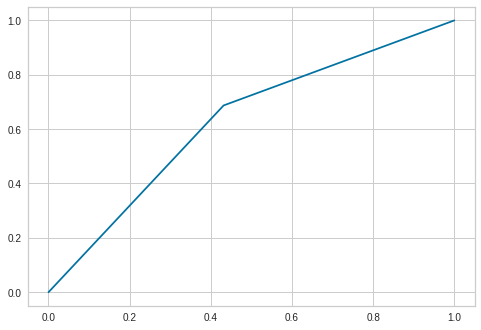

In [ ]:
fpr_rf,tpr_rf, thresholds_rf = roc_curve(y_test,y_pred_rf)
# print ROC curve
plt.plot(fpr_rf,tpr_rf)

# print AUC 
auc_rf = np.trapz(tpr_rf, fpr_rf)
print("AUC :",auc_rf)

### 3.4 로지스틱 회귀(Logistic Regression)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logit = LogisticRegression(fit_intercept=False)
result_logit = logit.fit(X_train,y_train)
result = DataFrame(logit.predict_proba(X_test)[:,1], columns=['logit_pred_prob'])

In [ ]:
#threshold 재설정 전의 값
fpr_logit,tpr_logit,thresholds_logit = roc_curve(y_test, result.logit_pred_prob)

In [ ]:
#threshold 설정 전 roc값
roc_auc = auc(fpr_logit, tpr_logit)
roc_auc 

0.6875704423241769

In [ ]:
#threshold 재설정
result['logit_binary']=np.where(result.logit_pred_prob>=0.26,1,0)

In [ ]:
#threshold 재설정 후의 값
fpr_logit2,tpr_logit2,thresholds_logit2 = roc_curve(y_test, result.logit_binary)

In [ ]:
logit_con = confusion_matrix(y_test, result.logit_binary)
logit_con

array([[ 4745, 30707],
       [ 1062, 34216]])

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, result.logit_binary).ravel()
(tn, fp, fn, tp)

(4745, 30707, 1062, 34216)

In [ ]:
tp/(tp+fn) # tpr = sensitivity

0.9698962526220307

In [ ]:
fp/(tn+fp) # fpr = 1-specificity

0.8661570574297642

In [ ]:
(tn+tp)/(tn+fp+fn+tp) # accuracy

0.5508412272020359

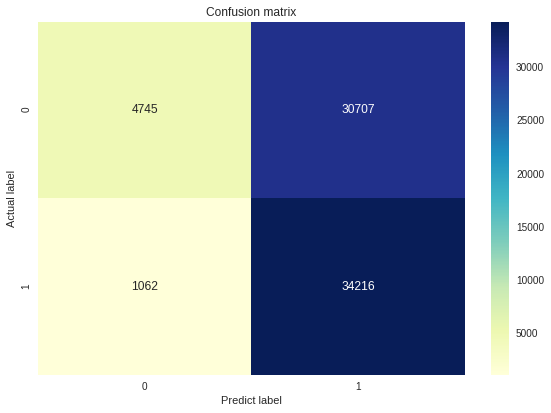

In [ ]:
#confusion matrix 시각화
sb.heatmap(pd.DataFrame(logit_con), annot=True, cmap='YlGnBu', fmt='g')
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predict label")
plt.show()

AUC : 0.5


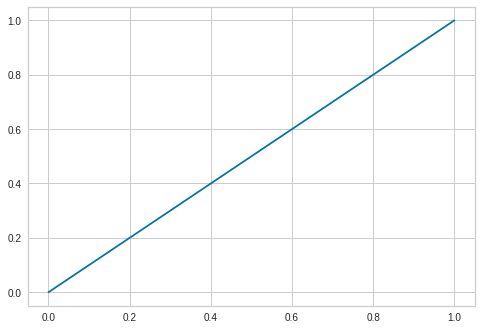

In [ ]:
# print ROC curve
plt.plot(fpr_logit2,fpr_logit2)

# print AUC
auc_logit2 = np.trapz(fpr_logit2,fpr_logit2)
print("AUC :",auc_logit2)

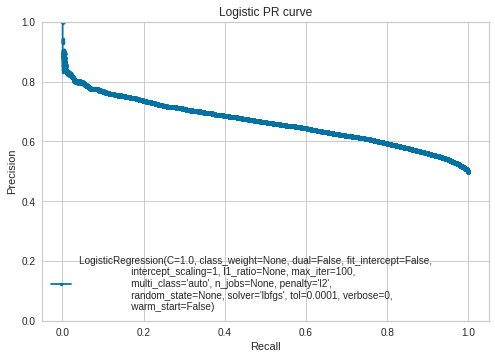

In [ ]:
#pr curve
from sklearn.metrics import precision_recall_curve
def plot_pr_curve(test_y, model_probs ,clf_name):
    precision, recall, _ = precision_recall_curve(test_y, model_probs)
    plt.plot(recall, precision, marker='.', label=clf_name)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    plt.ylim(0,1)

plot_pr_curve(y_test, result.logit_pred_prob, logit)
plt.title("Logistic PR curve")
plt.show()

### 3.5 라소 회귀(Lasso Regression)

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import accuracy_score, precision_score, auc, recall_score, f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from yellowbrick.classifier import ROCAUC

In [ ]:
##### 이 두 함수는 로지스틱 회귀모델의 게시글 코드에 존재한다.
##### Lasso와 Ridge의 예측 정확도를 측정하는데 사용할 것이다.

# 0/1 cut-off(임계값) 함수

def cut_off(y, threshold):
	Y = y.copy()
	Y[Y>threshold] = 1
	Y[Y<=threshold] = 0
	return (Y.astype(int))
    
# 정확도 acc 함수 

def acc(cfmat):
	acc = (cfmat[0,0] + cfmat[1,1]) / np.sum(cfmat)
	return acc

In [ ]:
lasso_cv = LassoCV().fit(X_train, y_train)   #Cross Validation을 통해서 lambda값을 설정한다
lasso_cv.alpha_

0.004431981156898047

In [ ]:
lasso = Lasso(alpha = lasso_cv.alpha_ ).fit(X_train,y_train) 

In [ ]:
# 회귀계수 출력 , 알파값 커질수록 회귀계수는 0에 수렴
lasso.coef_ 

array([ 1.87445493e-02,  1.46360042e-01, -1.56329805e-03,  4.27569610e-02,
        0.00000000e+00, -3.79281527e-02,  1.28075064e-02,  0.00000000e+00,
       -4.67384897e-03,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        3.16910243e-07, -2.14422749e-02,  0.00000000e+00,  1.75865746e-06,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        2.18555791e-02, -0.00000000e+00, -1.74131661e-02, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  1.08703175e-02, -1.49406621e-02,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  

In [ ]:
y_pred_lasso = lasso.predict(X_test)
y_pred_lasso = cut_off(y_pred_lasso, 0.26)
cfmat = confusion_matrix(y_test,y_pred_lasso)
print(acc(cfmat))

0.5374664216032801


In [ ]:
print(accuracy_score(y_test, y_pred_lasso))
print(precision_score(y_test, y_pred_lasso))
print(confusion_matrix(y_test, y_pred_lasso))

0.5374664216032801
0.5192097255325209
[[ 3378 32074]
 [  641 34637]]


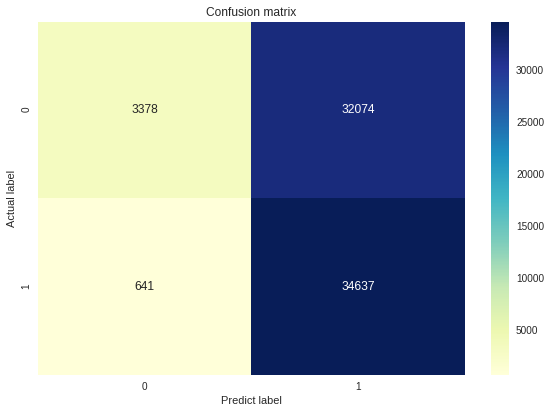

In [ ]:
a = confusion_matrix(y_test, y_pred_lasso)

sb.heatmap(a, annot=True, cmap='YlGnBu', fmt='g')
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predict label")
plt.show()

AUC : 0.5385568998394257


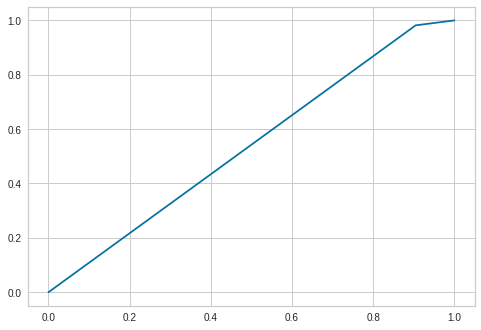

In [ ]:
fpr_lasso,tpr_lasso, thresholds_lasso = roc_curve(y_test,y_pred_lasso)
# print ROC curve
plt.plot(fpr_lasso,tpr_lasso)

# print AUC 
auc_lasso = np.trapz(tpr_lasso, fpr_lasso)
print("AUC :",auc_lasso)

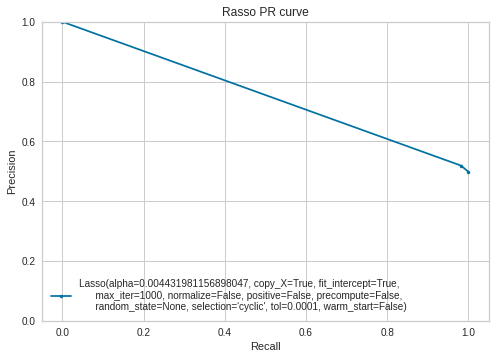

In [ ]:
#pr curve
from sklearn.metrics import precision_recall_curve
def plot_pr_curve(test_y, model_probs ,clf_name):
    precision, recall, _ = precision_recall_curve(test_y, model_probs)
    plt.plot(recall, precision, marker='.', label=clf_name)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    plt.ylim(0,1)

plot_pr_curve(y_test, y_pred_lasso,lasso)
plt.title("Rasso PR curve")
plt.show()

### 3.6 릿지 회귀(Ridge Regression)

In [ ]:
number=20
alphas = np.linspace(0,2,number)
alphas
# 지수 스케일로 조정: np.logspace
#alpha 낮게 -> 규제 약하게 : 데이터에 더 많은 피팅 시켜라 = 과대적합
#alpha 높게 -> 규제 강하게 : 모든 계수 값 0에 가깝게 = 과소적합

array([0.        , 0.10526316, 0.21052632, 0.31578947, 0.42105263,
       0.52631579, 0.63157895, 0.73684211, 0.84210526, 0.94736842,
       1.05263158, 1.15789474, 1.26315789, 1.36842105, 1.47368421,
       1.57894737, 1.68421053, 1.78947368, 1.89473684, 2.        ])

In [ ]:
#최적의 alpha찾기
ridge_cv=RidgeCV(alphas=alphas, cv=5).fit(X_train, y_train)
print(ridge_cv.alpha_)

2.0


In [ ]:
#최적의 alpha값 대입하여 트레이닝
ridge = Ridge(alpha = ridge_cv.alpha_).fit(X_train, y_train)

In [ ]:
#Ridge의 회귀계수(0에 가까워짐 but, 0은 아님) -> 
ridge.coef_

array([ 4.06101379e-02,  1.39082900e-01, -3.56987283e-03,  5.32400094e-02,
        4.47988505e-03, -4.21815848e-02,  5.92979663e-03,  3.91361827e-03,
       -6.28689558e-03, -4.92863533e-03,  2.32542488e-02, -1.78326856e-02,
        5.11090495e-08, -2.05875266e-02, -1.10840770e-02,  1.73290634e-06,
        6.90475498e-04, -6.81816272e-03, -1.67635739e-02, -1.01033619e-02,
       -7.69338117e-03, -1.05298299e-02, -1.03457593e-02, -8.24304060e-03,
       -7.56451370e-03,  1.14900374e-04,  3.10924996e-05, -7.81277105e-03,
        8.57284013e-02, -6.80966373e-03, -7.79423140e-03, -3.82478196e-02,
       -5.15137767e-03,  1.47543963e-02,  4.32486961e-02, -1.55766681e-02,
        1.60789533e-02, -5.02285276e-04, -1.55110348e-02, -1.00918298e-02,
        3.99204015e-03,  0.00000000e+00,  1.45195588e-02, -2.44794015e-02,
        3.49680149e-03,  3.83829895e-02,  1.33368979e-02, -1.23373514e-02,
        8.88919880e-04,  6.20749985e-02,  3.02398953e-03, -7.72965783e-02,
        2.08350051e-03,  

In [ ]:
y_pred_ridge = ridge.predict(X_test)
y_pred_ridge = cut_off(y_pred_ridge,0.26)
cfm_ridge = confusion_matrix(y_test,y_pred_ridge)
print(acc(cfm_ridge))

0.5509826099250672


In [ ]:
print(accuracy_score(y_test, y_pred_ridge))
print(precision_score(y_test, y_pred_ridge))
print(confusion_matrix(y_test, y_pred_ridge))

0.5509826099250672
0.5270463454000461
[[ 4684 30768]
 [  991 34287]]


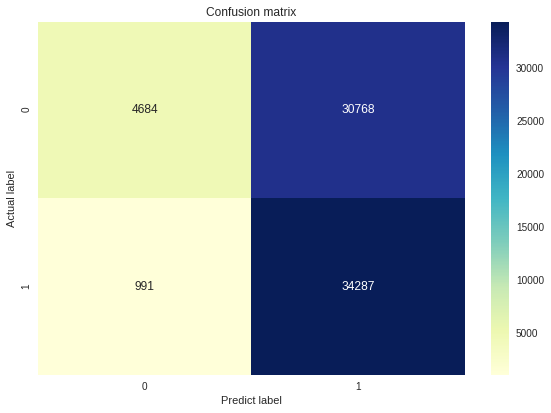

In [ ]:
a = confusion_matrix(y_test, y_pred_ridge)

sb.heatmap(a, annot=True, cmap='YlGnBu', fmt='g')
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predict label")
plt.show()

AUC : 0.5520155722931893


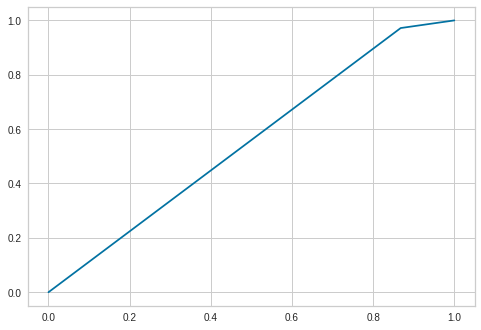

In [ ]:
## Ridge AUC, ROC Curve
fpr_ridge, tpr_ridge, thresholds_ridge = roc_curve(y_test,y_pred_ridge)

# print ROC curve
plt.plot(fpr_ridge,tpr_ridge)

# print AUC
auc_ridge = np.trapz(tpr_ridge,fpr_ridge)
print("AUC :",auc_ridge)

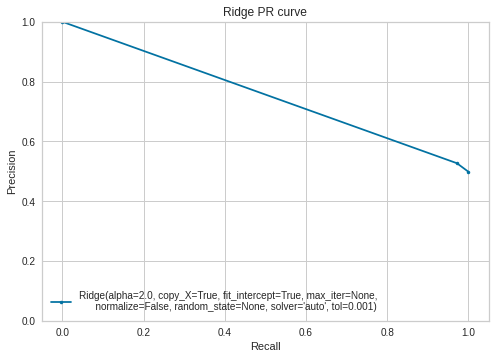

In [ ]:
#pr curve
from sklearn.metrics import precision_recall_curve
def plot_pr_curve(test_y, model_probs ,clf_name):
    precision, recall, _ = precision_recall_curve(test_y, model_probs)
    plt.plot(recall, precision, marker='.', label=clf_name)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    plt.ylim(0,1)

plot_pr_curve(y_test,y_pred_ridge, ridge)
plt.title("Ridge PR curve")
plt.show()

## 4. 결론

Text(0.5, 1.0, 'ROC curve')

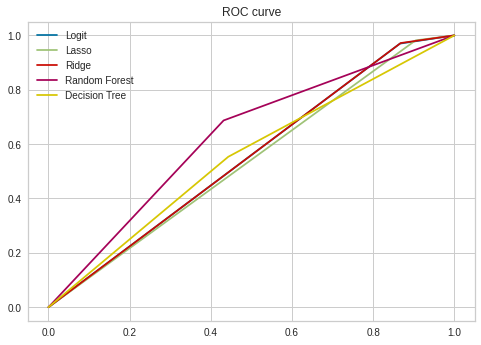

In [ ]:
plt.plot(fpr_logit2,tpr_logit2,label = 'Logit')
plt.plot(fpr_lasso,tpr_lasso,label = 'Lasso')
plt.plot(fpr_ridge,tpr_ridge,label = 'Ridge')
plt.plot(fpr_rf,tpr_rf,label = 'Random Forest')
plt.plot(fpr_tree,tpr_tree,label = 'Decision Tree')
plt.legend() ## 범례
plt.title("ROC curve")

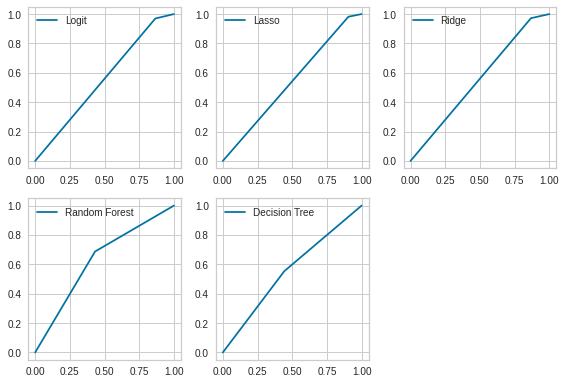

In [ ]:
plt.subplot(2,3,1)
plt.plot(fpr_logit2,tpr_logit2,label = 'Logit')
plt.legend() ## 범례
plt.subplot(2,3,2)
plt.plot(fpr_lasso,tpr_lasso,label = 'Lasso')
plt.legend() ## 범례
plt.subplot(2,3,3)
plt.plot(fpr_ridge,tpr_ridge,label = 'Ridge')
plt.legend() ## 범례
plt.subplot(2,3,4)
plt.plot(fpr_rf,tpr_rf,label = 'Random Forest')
plt.legend() ## 범례
plt.subplot(2,3,5)
plt.plot(fpr_tree,tpr_tree,label = 'Decision Tree')

plt.legend() ## 범례
plt.tight_layout()
plt.show()